# Adversarial Attack and Detection in Medical Images using Deap Learning

## Imports
Import common libraries and packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2

## Partition of data
Partitions the data based on the .csv file with file names of images and their corresponding name into three different .csv files for training, validation and testing under the folder `/data`. You can specify the ratios of training, validation and test data sets

Once partitioned into these three .csv files, one can use the same partitioning over and over when implementing the model, so to have comparative results.

In [8]:
# Imports
from data import partition_data

# Partition data into training, validation and test sets
partition_data(file='data/data_labels.csv', ratios=[0.70, 0.15, 0.15], out_path='data/')

NUMBER OF SAMPLES
    Class 0:   574    32%
    Class 1:   403    22%
    Class 2:   793    44%
    Total:    1770

PARTITIONED DATA
  Training:    70%, 1239 samples
    Class 0:   419    33%
    Class 1:   266    21%
    Class 2:   554    44%
    Total:    1239

  Validation:  15%, 265 samples
    Class 0:    80    30%
    Class 1:    68    25%
    Class 2:   117    44%
    Total:     265

  Testing:     15%, 266 samples
    Class 0:    75    28%
    Class 1:    69    25%
    Class 2:   122    45%
    Total:     266

  Total:       1770


## Import and transform data
Import the data and possibly augment it.

### Compute mean and standard deviation of data
Compute mean and standard deviation of training data after the pixels have been normalized to [0,1]. Once computed for a given training data set, there's no need to recalculate. Thus, use the computed values in the next cell.

In [9]:
# Imports
import albumentations as album
from albumentations.pytorch import ToTensorV2
from data import DatasetFromCSV, compute_mean_std



# Settings
image_size = 200

# Compute mean and standard deviation of images in training data
album_init = album.Compose([album.Resize(image_size, image_size),
                            album.Normalize(mean=[0,0,0], std=[1,1,1]),
                            ToTensorV2()])
dataset_train = DatasetFromCSV(image_root='./data/data_images/',
                               csv_path='./data/data_labels_train.csv',
                               transforms=album_init)
dataset_train_mean, dataset_train_std = compute_mean_std(dataset_train)
print(dataset_train_mean, dataset_train_std)

tensor([0.7761, 0.5934, 0.7643]) tensor([0.2124, 0.2961, 0.1778])


Computed mean and standard deviation for training data:

In [10]:
# Saved means and stds
dataset_train_mean = torch.tensor([0.7761, 0.5934, 0.7643])
dataset_train_std = torch.tensor([0.2124, 0.2961, 0.1778])

### Import training and validation data
Import training and validation datasets and put into data loaders. Specify what image size should be used and what augmentations of the data that is executed using the library albumentations. Also plot some examples from each data set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

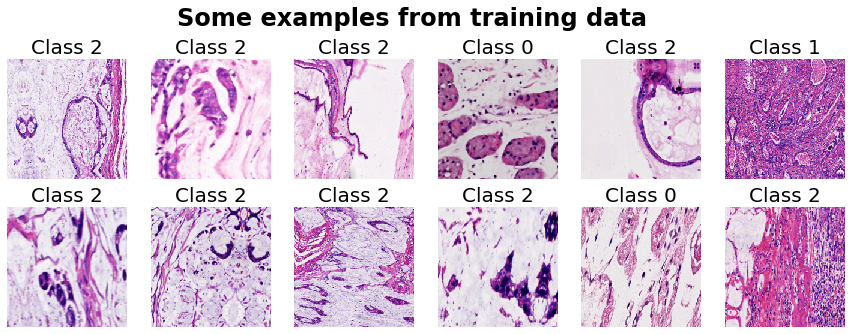

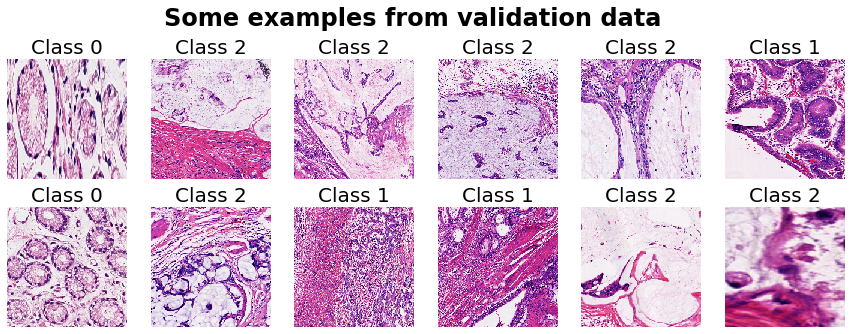

In [13]:
# Imports
import cv2
import albumentations as album
from albumentations.augmentations.transforms import GaussianBlur, MedianBlur, MotionBlur, RandomBrightness, \
                                                    RandomContrast,  VerticalFlip
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from data import DatasetFromCSV, compute_mean_std
from plot import plot_dataset, plot_image_list



# Settings
image_size = 200
batch_size = 16
num_workers = 4


# Augmentations of images and data using albumentations
album_train = album.Compose([
    album.Resize(image_size, image_size),
    album.OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
    album.OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
    album.VerticalFlip(p=0.5),
    album.HorizontalFlip(p=0.5),
    album.ShiftScaleRotate(
        shift_limit=0.2,
        scale_limit=0.2,
        rotate_limit=20,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        p=1,
    ),
    album.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),
    album.Normalize(mean=dataset_train_mean, std=dataset_train_std, max_pixel_value=1.0),
    ToTensorV2(),
])

album_validation = album.Compose([
    album.Resize(image_size, image_size),
    album.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),
    album.Normalize(mean=dataset_train_mean, std=dataset_train_std, max_pixel_value=1.0),
    ToTensorV2(),
])


# Load training data set
dataset_train = DatasetFromCSV(image_root='./data/data_images/',
                               csv_path='./data/data_labels_train.csv',
                               transforms=album_train)
# Load validation data set
dataset_validation = DatasetFromCSV(image_root='./data/data_images/',
                                    csv_path='./data/data_labels_validation.csv',
                                    transforms=album_validation)


# Plot some examples from training and validation data sets
rows = 2
cols = 6
image_width = 2.5
fig, axs = plot_dataset(dataset_train, rows=rows, cols=cols, image_width=image_width,
                        mean=dataset_train_mean, std=dataset_train_std)
fig.suptitle('Some examples from training data', fontsize=24, y=1.02, weight='bold')
fig, axs = plot_dataset(dataset_validation, rows=rows, cols=cols, image_width=image_width,
                        mean=dataset_train_mean, std=dataset_train_std)
fig.suptitle('Some examples from validation data', fontsize=24, y=1.02, weight='bold')
plt.show()


# Load data into loaders
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_validation = DataLoader(dataset=dataset_validation, batch_size=batch_size, num_workers=num_workers)

## Train classifier
Train classifier on training data and save models based on validation results. Can also load pre-trained models. During training, logs are saved and can be viewed via Tensorboard.

In [14]:
# Imports
import os
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.tensorboard import SummaryWriter
from models.efficientnet import EfficientNet
from core import core_efficientnet
from utils import create_save_path, SaveBestModel



# Settings
session = 1
num_classes = 3
initial_lr = 0.01
epochs = 30
load_model = False
save_path = './checkpoints/'+str(datetime.date(datetime.now()))+'_'+\
            str(image_size)+'x'+str(image_size)+'_'+str(epochs)+'_'+str(session)


# Use trained model
if load_model:
    model = torch.load('./checkpoints/2021-11-04_128x128_20_1/models/best.pt')
    
    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function
    loss_func = torch.nn.CrossEntropyLoss().to(device)

    # Optimizer
    optimizer = torch.optim.Adam(lr=initial_lr, params=model.parameters(), betas=(0.9, 0.99))

# Train model
else:
    # Model
    model = EfficientNet.from_name('efficientnet-b0', num_classes=num_classes)

    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function
    loss_func = torch.nn.CrossEntropyLoss().to(device)

    # Optimizer
    optimizer = torch.optim.Adam(lr=initial_lr, params=model.parameters(), betas=(0.9, 0.99))

    # Learning rate decay
    optimizer_step = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    # Weight save path
    log_path, weight_path = create_save_path(save_path)

    # Initialize log writer
    log_writer = SummaryWriter(log_path, comment=f'LR_{initial_lr}_BS_{batch_size}')

    # Save current model as best model
    save_best_model = SaveBestModel(epoch=None, model=model, epochs=epochs, monitor_value=None, weight_path=weight_path,
                                    best=None)

    # Setup
    train_total = len(dataset_train)
    valid_total = len(dataset_validation)
    time_start = time.time()

    print('Started:', str(datetime.now()))
    for epoch in range(epochs):
        print('Epoch {:<3}'.format(epoch+1), end='   ')
        
        # Training
        train_acc, train_loss = core_efficientnet.train(model, loader_train, device, loss_func, optimizer, train_total, epoch)
        print('Training accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*train_acc,2),
            np.around(train_loss,5)),
            end='   ')

        # Validation
        valid_acc, valid_loss = core_efficientnet.valid(model, loader_validation, device, loss_func, optimizer, valid_total,
                                                        epoch)
        print('Validation accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*valid_acc,2),
            np.around(valid_loss,5)),
            end='\n')

        # Optimize
        optimizer_step.step()
        lr = optimizer.param_groups[0]['lr']

        # Save model if better than previously best model
        save_best_model.epoch = epoch
        save_best_model.monitor_value = valid_acc
        save_best_model.run(model)

        # Write to log
        log_writer.add_scalar("Train/Training_accuracy", train_acc, epoch)
        log_writer.add_scalar("Train/Validation_accuracy", valid_acc, epoch)
        log_writer.add_scalar("Train/Training_loss", train_loss, epoch)
        log_writer.add_scalar("Train/Validation_loss", valid_loss, epoch)
        log_writer.add_scalar("Train/Learning_rate", lr, epoch)

    time_elapsed = time.time() - time_start
    print('Ended:', str(datetime.now()))
    print('Total training time: {}'.format(str(timedelta(seconds=time_elapsed))))

Started: 2021-11-05 10:23:05.307022
Epoch 1     Training accuracy: 51.25%, loss: 1.08361   Validation accuracy: 38.49%, loss: 1.0411
Saved model.
Epoch 2     Training accuracy: 69.01%, loss: 0.71494   Validation accuracy: 34.72%, loss: 4.38053
Epoch 3     Training accuracy: 78.29%, loss: 0.55132   Validation accuracy: 49.43%, loss: 1.45257
Saved model.
Epoch 4     Training accuracy: 81.84%, loss: 0.48176   Validation accuracy: 40.38%, loss: 28.07093
Epoch 5     Training accuracy: 77.08%, loss: 0.59288   Validation accuracy: 39.25%, loss: 47.54408
Epoch 6     Training accuracy: 85.39%, loss: 0.41884   Validation accuracy: 77.74%, loss: 0.9186
Saved model.
Epoch 7     Training accuracy: 89.02%, loss: 0.29137   Validation accuracy: 91.32%, loss: 0.62596
Saved model.
Epoch 8     Training accuracy: 88.78%, loss: 0.31294   Validation accuracy: 90.94%, loss: 0.22699
Epoch 9     Training accuracy: 90.4%, loss: 0.25203   Validation accuracy: 83.4%, loss: 0.59754
Epoch 10    Training accuracy: 9

## Test
Use trained model and get results for test data.

In [15]:
from plot import plot_dataset, plot_image_list

# Augmentations of images and data using albumentations
album_test = album.Compose([
    album.Resize(image_size, image_size),
    album.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),
    album.Normalize(mean=dataset_train_mean, std=dataset_train_std, max_pixel_value=1.0),
    ToTensorV2(),
])

# Load test data set
dataset_test = DatasetFromCSV(image_root='./data/data_images/',
                              csv_path='./data/data_labels_test.csv',
                              transforms=album_test)

# Load data into loaders
loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=num_workers)

# Test
test_total = len(dataset_test)
test_acc, test_loss, wrong_images, wrong_labels, correct_labels = \
    core_efficientnet.test(model, loader_test, device, loss_func, optimizer, test_total, epoch=1)

print('Test accuracy:   '+str(np.around(100*test_acc,2))+'%')
print('Test loss:       '+str(np.around(test_loss,5)))

Test accuracy:   96.62%
Test loss:       0.09346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


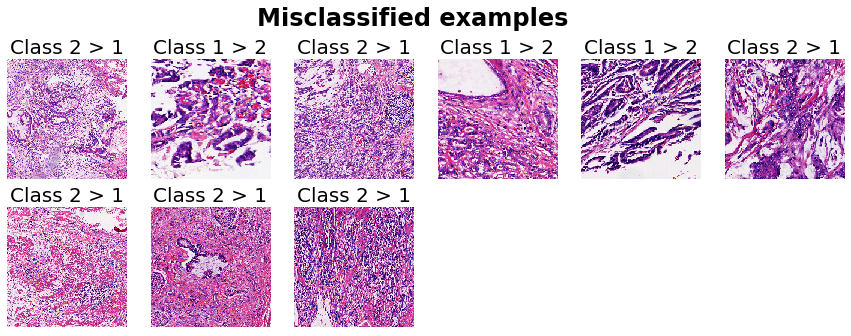

In [16]:
# Plot misclassified samples
rows = 2
cols = 6
image_width = 2.5
fig, axs = plot_image_list(wrong_images, wrong_labels, correct_labels, rows=rows, cols=cols, image_width=image_width,
                        mean=dataset_train_mean, std=dataset_train_std)
fig.suptitle('Misclassified examples', fontsize=24, y=1.02, weight='bold')
plt.show()